<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-корпусов-TF-IDF" data-toc-modified-id="Подготовка-корпусов-TF-IDF-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка корпусов TF-IDF</a></span></li><li><span><a href="#Подготовка-корпусов-Bert" data-toc-modified-id="Подготовка-корпусов-Bert-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка корпусов Bert</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей-с-корпусами-TF-IDF" data-toc-modified-id="Обучение-моделей-с-корпусами-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение моделей с корпусами TF-IDF</a></span></li><li><span><a href="#Обучение-моделей-с-корпусами-Bert" data-toc-modified-id="Обучение-моделей-с-корпусами-Bert-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение моделей с корпусами Bert</a></span></li><li><span><a href="#Сравнение-результатов-моделей-обученных-на-корпусах-TF-IDF-и-Bert" data-toc-modified-id="Сравнение-результатов-моделей-обученных-на-корпусах-TF-IDF-и-Bert-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Сравнение результатов моделей обученных на корпусах TF-IDF и Bert</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Проект для анализа таксичности нового сервиса интернет магазина.

Интернет-магазин запускает новый сервис и теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные на основании набора данных с разметкой о токсичности правок. Построеная модель должна иметь метрику качества *F1* не меньше 0.75. 

**В ходе проекта необходимо сделать следующее**

1. Загрузить и подготовить данные.
2. Обучить и проанализировать разные модели. 
3. Сделать выводы.


## Подготовка

Строить модель будем при помощи TF-IDF.

Импортируем требуемые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

import re 
from tqdm import notebook 
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords
import nltk

import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_precision_recall_curve

In [2]:
tqdm.pandas()

Прочитаем данные из файла и выведем на экран первые 5 строк датасета.

In [3]:
data = pd.read_csv("toxic_comments.csv")

In [4]:
display(data.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Выведем информацию по датасету и изучим данные

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
data.describe(include='all')

,text,toxic
count,159571,159571.000000
unique,159571,NaN
top,Explanation\nWhy the edits made under my usern...,NaN
freq,1,NaN
mean,NaN,0.101679
std,NaN,0.302226
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


Как видно из описания столбца 'toxic'у нас имеется достаточно сильный дисбаланс классов. Построим графическое отображение данной метрики, чтобы лучши представлять степень дисбаланса

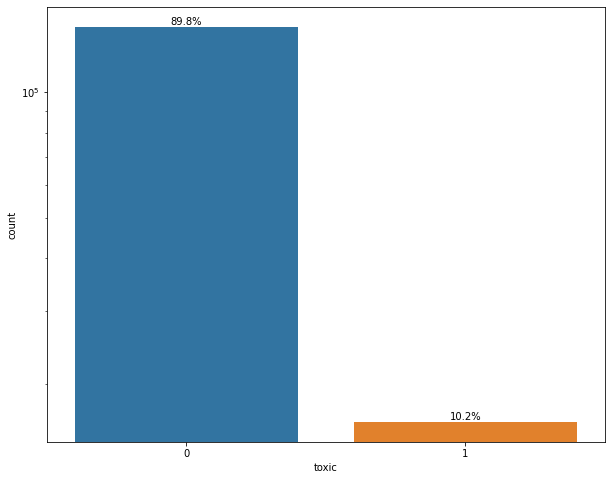

In [7]:
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = data['toxic'])
ax.set_yscale('log')
total=len(data['toxic'])
for p in ax.patches:
    px = p.get_bbox().get_points()[:,0]
    py = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*py/total), (px.mean(), py), ha='center', va='bottom')
    

Диаграмма подтверждает наши предварительные выводы, что модель имеет очень сильный дисбаланс целевого признака, поэтом использовать в качестве метрики accuracy не имеет смысла (так как даже, если модель будет предсказывать все сообщения как не токсичные, данная метрика будет равна почти 0,9). Поэтому в данном проекте восользуемся f1 метрикой.

### Подготовка корпусов TF-IDF

Цитаты приведены на английском языке, это необходимо будет учесть при создании регулярных выражений.  Сам датасет заполнен полностью, поэтому можем начать с ним рабоать. Создадим столбец с лематизированным текстом, для этого из nltk загузим требуемые данные и инициализируем лематизатор.

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ярослав\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ярослав\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ярослав\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
lemmatizer = WordNetLemmatizer()

Создадим две функции: одну для того, чтобы выбрать из текста только слова на латинице, вторую - непосредственно для лематизации текста.

In [13]:
def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    new_text = new_text.split()
    return ' '.join(new_text)

def lemmatize(text):

    text_list = nltk.word_tokenize(text)
    lemm_list = []
    
    for word in text_list:
        lemm_list.append(lemmatizer.lemmatize(word))
    
    lemm_text = " ".join(lemm_list)
        
    return lemm_text

Проверим работоспособность наших функций передав им фразу на английском языке.

In [14]:
text_1 = "More I can't make any real suggestions"
text_1 = clear_text(text_1)
new_text_1 = lemmatize(text_1)
new_text_1

'More I can t make any real suggestion'

Функции работают нормально, поэтому применим их к нашим данным. Учитывая, что размер датасета достаточно большой, то операцию лемматизации будем производить батчами.

In [15]:
data['lemm_text'] = data['text'].progress_apply(clear_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [16]:
batch_size = 1000
for i in notebook.tqdm(range(data.shape[0] // batch_size)):
        data['lemm_text'][i:i+batch_size] = data['lemm_text'][i:i+batch_size].apply(lemmatize) 
        

  0%|          | 0/159 [00:00<?, ?it/s]

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_12284\211739927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemm_text'][i:i+batch_size] = data['lemm_text'][i:i+batch_size].apply(lemmatize)


Выведем на экран получившийся датасет.

In [17]:
display(data)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


Функции отработали корректно. Данные преобразовались нормально.

Чтобы получить правильный результат на тесте выделим целевой признак и разделем исходные данные на тестовую и тренировочную выборку.

In [18]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123) 

In [19]:
target_train = data_train['toxic']
target_test = data_test['toxic']

In [20]:
corpus_train = data_train['lemm_text']
corpus_test = data_test['lemm_text']

Очистим корпус от стоп слов и вычислим TF-IDF для корпусов. Обучать TF-IDF будем только на трэйне. После применения TF-IDF выведем информацию о размерах получившихся корпусов, чтобы убедиться, что код отработал правильно.

In [21]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ярослав\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
tf_idf = count_tf_idf.fit(corpus_train) 

In [23]:
corpus_train = tf_idf.transform(corpus_train)
corpus_train.shape

(127656, 148034)

In [24]:
corpus_test = tf_idf.transform(corpus_test)
corpus_test.shape

(31915, 148034)

Размерности по количеству признаков в корпусах совпали, поэтому можно сделать вывод, что вероятнее всего, преобразование проведено корректно

### Подготовка корпусов Bert

Проведём подготовку данных для корпусов полученных при помощи предообученной модели Bert. Для этого заново откроем файл с данными, чтобы работать первоначальной информацией.

In [25]:
data = pd.read_csv("toxic_comments.csv")

Создадим экземпляр модели, токинайзера и весов для Берта.

In [26]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, 
                                                   transformers.BertTokenizer,
                                                   'bert-base-uncased')

bert_model = model_class.from_pretrained(pretrained_weights).cuda()
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Проведём токенизацию данных.

In [27]:
%%time
tokenized = data['text'].progress_apply(
    lambda x: bert_tokenizer.encode(x, max_length=512, add_special_tokens=True))

  0%|          | 0/159571 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: total: 2min 53s
Wall time: 2min 54s


Приведём тексты в корпусе к единой длине (padding)

In [28]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

Выведем информацию по размерам получившегося корпуса, поскольку bert не работает с текстами длиной больше 512 токенов

In [29]:
padded.shape

(159571, 512)

Создадим маску, чтобы модель могла определить какие токены важные

In [30]:
attention_mask = np.where(padded != 0, 1, 0)

Проведём эмбэдинг. Данные будем подавать бачами по 50 строк.

In [31]:
%%time
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size+1)):
    
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
    
    with torch.no_grad():            
        batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    

  0%|          | 0/3192 [00:00<?, ?it/s]

CPU times: total: 1h 9min 5s
Wall time: 1h 9min 13s


Выделим корпуса для обучения и теста, а также целевые признаки.

In [32]:
target = data['toxic']
corpus_bert = np.concatenate(embeddings)

corpus_train_bert, corpus_test_bert, target_train_bert, target_test_bert = train_test_split(corpus_bert, target, 
                                                                                           test_size=0.2, 
                                                                                           random_state=123) 

Выведем информацию по размерам тренировочного корпуса и таргета.

In [33]:
corpus_train_bert.shape

(127656, 768)

In [34]:
target_train_bert.shape

(127656,)

Выведем информацию по размерам тестового корпуса и таргета.

In [35]:
corpus_test_bert.shape

(31915, 768)

In [36]:
target_test_bert.shape

(31915,)

### Выводы

В данном разделе были загружены исходные данные, проведён анализ дисбаланса целевого признака, был создан столбец с лемматизированным текстом из которого были созданы корпуса для обучения и теста. Также были созданы корпуса для обучения из обучающей и тестовой выборки при помощи TF-IDF и нейросети Bert.

## Обучение

### Обучение моделей с корпусами TF-IDF

Рассмотрим несколько моделей и подберём наиболее подходящую для решения задачи анализа тональности текста.

Обучим модель **логистической регрессии**.

In [37]:
lin_model = LogisticRegression()
lin_model.fit(corpus_train, target_train)

predictions = lin_model.predict(corpus_test)
print('Результат f1 для линейной модели равен', f1_score(target_test, predictions))

Результат f1 для линейной модели равен 0.7334615384615384


C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Попробуем улучшить показатель логистической модели, указав информацию, что классы несбалансированы.

In [38]:
lin_model = LogisticRegression(class_weight='balanced')
lin_model.fit(corpus_train, target_train)

predictions = lin_model.predict(corpus_test)
print('Результат f1 для линейной модели равен', f1_score(target_test, predictions))

Результат f1 для линейной модели равен 0.7498959633791095


C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменение гиперпараметра class_weight на 'balanced' позволило улучшить качество модели, однако, пока она не удовлетворяет требованиям технического задания.

Попробуем улучшить модель, для этого подберём гиперпараметр C при помощи LogisticRegressionCV 

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-1, 3, 50)

logit_searcher = LogisticRegressionCV(Cs=c_values, 
                                      cv=skf, 
                                      verbose=1, 
                                      n_jobs=-1, 
                                      class_weight='balanced', 
                                      scoring='f1')
logit_searcher.fit(corpus_train, target_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(Cs=array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17...
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, scoring='f1', verbose=1)

In [40]:
print('Результат f1 на тренировочной выборке при кросс валидации', logit_searcher.scores_[1].max())

Результат f1 на тренировочной выборке при кросс валидации 0.7778808684357024


In [41]:
print('Оптимальное значение гиперпараметра C:', logit_searcher.C_)

Оптимальное значение гиперпараметра C: [10.98541142]


Проверим полученные данные на тестовой выборке

In [42]:
predictions = logit_searcher.predict(corpus_test)
print('Результат f1 для линейной модели после подбора uиперпараметра C равен', f1_score(target_test, predictions))

Результат f1 для линейной модели после подбора uиперпараметра C равен 0.7711413364872857


Поскольку на тренировочной и тестовой выборке метрики примерно равны, можно предположить, что нам не только удалось улучшить модель, но и добиться того, чтобы она не переобучилась.

Обучим модель **случайного леса**.

In [43]:
forest_model = RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=123)
forest_model.fit(corpus_train, target_train)

predictions = forest_model.predict(corpus_test)
print('f1',f1_score(target_test, predictions))
print('accuracy',accuracy_score(target_test, predictions))

f1 0.38476079685909553
accuracy 0.7348582171392762


Модель случайного леса очень не подходит для работы с данной задачей. Показатель метрики f1 очень низкий, попробуем улучшить его подобрав гиперпараметры при помощи GridSerchCV.

In [44]:
forest = RandomForestClassifier(class_weight='balanced', random_state=123)

forest_params = {'max_depth': range(1,11),
                'n_estimators': range(5, 100, 5)}

forest_grid = GridSearchCV(forest, 
                         forest_params,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'f1',
                         verbose=True)

In [45]:
forest_grid.fit(corpus_train, target_train)

Fitting 5 folds for each of 190 candidates, totalling 950 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'n_estimators': range(5, 100, 5)},
             scoring='f1', verbose=True)

Лучшее сочетание параметров для модели случайного леса:

In [46]:
forest_grid.best_params_

{'max_depth': 10, 'n_estimators': 95}

In [47]:
print('Лучший результат f1 для модели случайного леса на кросс валидации при оптимальных параметрах равен', forest_grid.best_score_)

Лучший результат f1 для модели случайного леса на кросс валидации при оптимальных параметрах равен 0.3622002419336437


Посчитаем значение метрики на тестовой выборке

In [48]:
predictions = forest_grid.predict(corpus_test)
print('Результат f1 для модели случайного леса с оптимальными параметрами на тестовой выборке равен', f1_score(target_test, predictions))

Результат f1 для модели случайного леса с оптимальными параметрами на тестовой выборке равен 0.34767419292230056


Даже с оптимальными параметрами модель случайного леса имеет весьма плохой результат и не дотягивает до установленного baseline.

Обучим модель **k ближайших соседей**.

In [49]:
knn_model = KNeighborsClassifier()
knn_model.fit(corpus_train, target_train)

predictions = knn_model.predict(corpus_test)
print('f1',f1_score(target_test, predictions))

f1 0.27297297297297296


Постараемся улучшить показатель модели knn подобрав количество оптимальное количество ближайших соседей.

In [50]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors': range(1,11)}

knn_grid = GridSearchCV(knn, 
                         knn_params,
                         cv=5, 
                         n_jobs=-1,
                         scoring = 'f1',
                         verbose=True)

In [51]:
knn_grid.fit(corpus_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 11)}, scoring='f1',
             verbose=True)

Оптимальное количество соседей для модели KNN:

In [52]:
knn_grid.best_params_

{'n_neighbors': 1}

In [53]:
print('Лучший результат f1 для модели k ближайших соседей на кросс валидации при оптимальных параметрах (на кросс валидации) равен', knn_grid.best_score_)

Лучший результат f1 для модели k ближайших соседей на кросс валидации при оптимальных параметрах (на кросс валидации) равен 0.35310748756851107


Посмотрим результат на тестовой вборке 

In [54]:
predictions = knn_grid.predict(corpus_test)
print('Результат f1 для модели случайного леса с оптимальными параметрами на тестовой выборке равен', f1_score(target_test, predictions))

Результат f1 для модели случайного леса с оптимальными параметрами на тестовой выборке равен 0.4063579820317899


На тестовой выборке модель KNN получила более хороший показатель метрики f1, чем модель случайного леса, однако на трейне с кросс-валидацией у модели KNN качество хуже. При этом обе модели всё равно уступает логистической ригресии. 

Обучим модель **CatBoost**.

In [55]:
cat_model = CatBoostClassifier(random_state=123, 
                               verbose=100, 
                               class_weights=[1, 3]                        
                               )
cat_model.fit(corpus_train, target_train)

predictions = cat_model.predict(corpus_test)
print('f1',f1_score(target_test, predictions))

Learning rate set to 0.081698
0:	learn: 0.6466171	total: 934ms	remaining: 15m 33s
100:	learn: 0.3040436	total: 1m 9s	remaining: 10m 14s
200:	learn: 0.2628437	total: 2m 15s	remaining: 9m
300:	learn: 0.2386347	total: 3m 22s	remaining: 7m 50s
400:	learn: 0.2221686	total: 4m 28s	remaining: 6m 41s
500:	learn: 0.2091541	total: 5m 35s	remaining: 5m 33s
600:	learn: 0.1989944	total: 6m 41s	remaining: 4m 26s
700:	learn: 0.1906123	total: 7m 47s	remaining: 3m 19s
800:	learn: 0.1828781	total: 8m 53s	remaining: 2m 12s
900:	learn: 0.1764432	total: 10m	remaining: 1m 5s
999:	learn: 0.1705276	total: 11m 5s	remaining: 0us
f1 0.7858217689349607


Подберём оптимальное количество итераций при помощи встроенной кроссвалидации

In [56]:
params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': 'F1'
}

cv_data = cv(
    params=params, 
    pool=Pool(data=corpus_train, label=target_train),
    fold_count=5,
    shuffle=False, 
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)

Training on fold [0/5]

bestTest = 0.1280226331
bestIteration = 2997

Training on fold [1/5]

bestTest = 0.1322197116
bestIteration = 2995

Training on fold [2/5]

bestTest = 0.1281280602
bestIteration = 2999

Training on fold [3/5]

bestTest = 0.13084494
bestIteration = 2996

Training on fold [4/5]

bestTest = 0.1320847301
bestIteration = 2996



In [57]:
best_value = np.max(cv_data['test-F1-mean'])
best_iter = np.argmax(cv_data['test-F1-mean'])
print("Лучшее значение F1: {:.4f}+/-{:.3f} на шаге {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Лучшее значение F1: 0.7485+/-0.002 на шаге 2995


In [97]:
cat_model = CatBoostClassifier(random_state=123, 
                               verbose=100, 
                               iterations=best_iter,
                               class_weights=[1, 3]                        
                               )
cat_model.fit(corpus_train, target_train)

predictions = cat_model.predict(corpus_test)
print('Результат f1 для модели CatBoost после подбора гиперпараметров',f1_score(target_test, predictions))

Learning rate set to 0.033992
0:	learn: 0.6730537	total: 724ms	remaining: 31m 24s
100:	learn: 0.3554637	total: 1m 10s	remaining: 29m 3s
200:	learn: 0.3157775	total: 2m 20s	remaining: 27m 58s
300:	learn: 0.2930791	total: 3m 29s	remaining: 26m 39s
400:	learn: 0.2757000	total: 4m 36s	remaining: 25m 18s
500:	learn: 0.2618765	total: 5m 43s	remaining: 24m 1s
600:	learn: 0.2505332	total: 6m 51s	remaining: 22m 49s
700:	learn: 0.2412890	total: 7m 58s	remaining: 21m 37s
800:	learn: 0.2333915	total: 9m 5s	remaining: 20m 27s
900:	learn: 0.2263918	total: 10m 12s	remaining: 19m 17s
1000:	learn: 0.2202805	total: 11m 20s	remaining: 18m 7s
1100:	learn: 0.2146513	total: 12m 27s	remaining: 16m 59s
1200:	learn: 0.2096597	total: 13m 34s	remaining: 15m 50s
1300:	learn: 0.2050804	total: 14m 42s	remaining: 14m 42s
1400:	learn: 0.2009298	total: 15m 49s	remaining: 13m 34s
1500:	learn: 0.1971187	total: 16m 56s	remaining: 12m 25s
1600:	learn: 0.1934564	total: 18m 3s	remaining: 11m 17s
1700:	learn: 0.1899547	total

Построим precision-recall кривые для данных моделей и сравним их

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve 

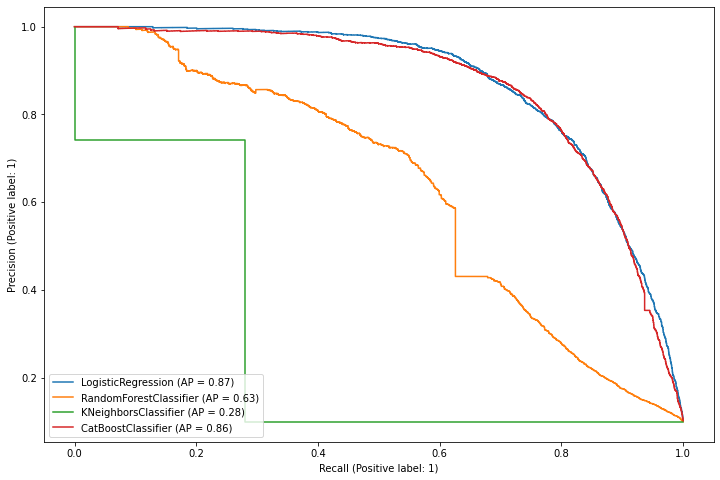

In [59]:
plt.figure(figsize =(12,8))
roc_disp = plot_precision_recall_curve(logit_searcher, corpus_test, target_test, ax=plt.axes(), name='LogisticRegression')
plot_precision_recall_curve(forest_grid, corpus_test, target_test, ax=roc_disp.ax_, name='RandomForestClassifier')
plot_precision_recall_curve(knn_grid, corpus_test, target_test, ax=roc_disp.ax_, name='KNeighborsClassifier')
plot_precision_recall_curve(cat_model, corpus_test, target_test, ax=roc_disp.ax_, name='CatBoostClassifier')

Из полученной диаграммы видно, что лучше всего себя показывают модели логистической регрессии и CatBoost, Другие соседи значительно уступают им. 

### Обучение моделей с корпусами Bert

Обучим модели на корпусах полученных при помощи предообученной нейросети Bert. Чтобы сократить время обучения для начала обучим все модели а потом подберём гиперпараметры для лучших из них.

Обучим модель **логистической регрессии**

In [60]:
lin_model_bert = LogisticRegression(class_weight='balanced')
lin_model_bert.fit(corpus_train_bert, target_train_bert)

predictions = lin_model_bert.predict(corpus_test_bert)
print('Результат f1 для линейной модели на корпусе Bert равен', f1_score(target_test_bert, predictions))

Результат f1 для линейной модели на корпусе Bert равен 0.6423992673992674


C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Обучим модель **случайного леса**.

In [61]:
forest_model_bert = RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=123, n_jobs=-1)
forest_model_bert.fit(corpus_train_bert, target_train_bert)

predictions = forest_model_bert.predict(corpus_test_bert)
print('Результат f1 для модели случайного леса на корпусе Bert равен',f1_score(target_test_bert, predictions))

Результат f1 для модели случайного леса на корпусе Bert равен 0.5875394321766562


Обучим модель **k ближайших соседей**.

In [62]:
knn_model_bert = KNeighborsClassifier()
knn_model_bert.fit(corpus_train_bert, target_train_bert)

predictions = knn_model_bert.predict(corpus_test_bert)
print('Результат f1 для модели KNN на корпусе Bert равен',f1_score(target_test_bert, predictions))

Результат f1 для модели KNN на корпусе Bert равен 0.6071558963125229


Обучим модель **CatBoost**.

In [81]:
cat_model_bert = CatBoostClassifier(random_state=123, 
                               verbose=100, 
                               class_weights=[1, 3]                        
                               )
cat_model_bert.fit(corpus_train_bert, target_train_bert)

predictions = cat_model_bert.predict(corpus_test_bert)
print('Результат f1 для модели CatBoost на корпусе Bert равен',f1_score(target_test_bert, predictions))

Learning rate set to 0.081698
0:	learn: 0.6330550	total: 130ms	remaining: 2m 10s
100:	learn: 0.2401339	total: 12.8s	remaining: 1m 53s
200:	learn: 0.2117312	total: 24.5s	remaining: 1m 37s
300:	learn: 0.1907797	total: 35.8s	remaining: 1m 23s
400:	learn: 0.1737639	total: 47s	remaining: 1m 10s
500:	learn: 0.1595101	total: 58.1s	remaining: 57.9s
600:	learn: 0.1467569	total: 1m 9s	remaining: 46s
700:	learn: 0.1354189	total: 1m 20s	remaining: 34.3s
800:	learn: 0.1252782	total: 1m 31s	remaining: 22.8s
900:	learn: 0.1162055	total: 1m 42s	remaining: 11.3s
999:	learn: 0.1079742	total: 1m 54s	remaining: 0us
Результат f1 для модели CatBoost на корпусе Bert равен 0.7145522388059701


Лучшими оказались модель линейной регресси и CatBoost подберём для них гиперапарметры. Начнём с линейной модели.

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-1, 3, 50)

logit_searcher_bert = LogisticRegressionCV(Cs=c_values, 
                                      cv=skf, 
                                      verbose=1, 
                                      n_jobs=-1, 
                                      class_weight='balanced', 
                                      scoring='f1')
logit_searcher_bert.fit(corpus_train_bert, target_train_bert)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.7min finished
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(Cs=array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17...
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, scoring='f1', verbose=1)

In [66]:
print('Результат f1 для логистической регресии после кроссвалидации на корпусе Bert равен', logit_searcher_bert.scores_[1].max())

Результат f1 для логистической регресии после кроссвалидации на корпусе Bert равен 0.6570986351484451


In [67]:
print('Оптимальное значение гиперпараметра C:', logit_searcher_bert.C_)

Оптимальное значение гиперпараметра C: [0.21209509]


In [69]:
predictions = logit_searcher_bert.predict(corpus_test_bert)
print('Результат f1 для тестовой выборки для логистической регресии после кроссвалидации на корпусе Bert равен', f1_score(target_test_bert, predictions))

Результат f1 для тестовой выборки для логистической регресии после кроссвалидации на корпусе Bert равен 0.6457254631227707


Подберём количество итераций CatBoost

In [76]:
params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': 'F1'
}

cv_data = cv(
    params=params, 
    pool=Pool(data=corpus_train_bert, label=target_train_bert),
    fold_count=5,
    shuffle=False, 
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)

Training on fold [0/5]

bestTest = 0.1381530263
bestIteration = 2896

Training on fold [1/5]

bestTest = 0.1365992134
bestIteration = 2929

Training on fold [2/5]

bestTest = 0.1375223736
bestIteration = 2988

Training on fold [3/5]

bestTest = 0.1371279026
bestIteration = 2920

Training on fold [4/5]

bestTest = 0.1389634915
bestIteration = 2995



In [77]:
best_value = np.max(cv_data['test-F1-mean'])
best_iter = np.argmax(cv_data['test-F1-mean'])
print("Лучшее значение F1: {:.4f}+/-{:.3f} на шаге {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Лучшее значение F1: 0.7025+/-0.001 на шаге 2602


Обучим модель CatBoost с оптимальным значением итераций.

In [82]:
cat_model_bert = CatBoostClassifier(random_state=123, 
                               verbose=100,
                               iterations=best_iter, 
                               class_weights=[1, 3]    
                               )
cat_model_bert.fit(corpus_train_bert, target_train_bert)

predictions = cat_model_bert.predict(corpus_test_bert)
print('Результат f1 для модели CatBoost после подбора гиперпараметров, на корпусе Bert равен',f1_score(target_test_bert, predictions))

Learning rate set to 0.033992
0:	learn: 0.6671133	total: 126ms	remaining: 5m 27s
100:	learn: 0.2789089	total: 13.1s	remaining: 5m 23s
200:	learn: 0.2469679	total: 25.3s	remaining: 5m 2s
300:	learn: 0.2318378	total: 37.2s	remaining: 4m 44s
400:	learn: 0.2199272	total: 48.7s	remaining: 4m 27s
500:	learn: 0.2090146	total: 1m	remaining: 4m 12s
600:	learn: 0.1997629	total: 1m 11s	remaining: 3m 58s
700:	learn: 0.1913842	total: 1m 23s	remaining: 3m 45s
800:	learn: 0.1837381	total: 1m 34s	remaining: 3m 32s
900:	learn: 0.1768528	total: 1m 45s	remaining: 3m 19s
1000:	learn: 0.1704177	total: 1m 56s	remaining: 3m 7s
1100:	learn: 0.1643632	total: 2m 8s	remaining: 2m 54s
1200:	learn: 0.1585512	total: 2m 19s	remaining: 2m 42s
1300:	learn: 0.1531536	total: 2m 30s	remaining: 2m 30s
1400:	learn: 0.1480188	total: 2m 41s	remaining: 2m 18s
1500:	learn: 0.1431475	total: 2m 52s	remaining: 2m 6s
1600:	learn: 0.1383823	total: 3m 3s	remaining: 1m 54s
1700:	learn: 0.1337286	total: 3m 15s	remaining: 1m 43s
1800:	

Сравним полученные модели на корпусах Bert при помощи графика precision-recall

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve 

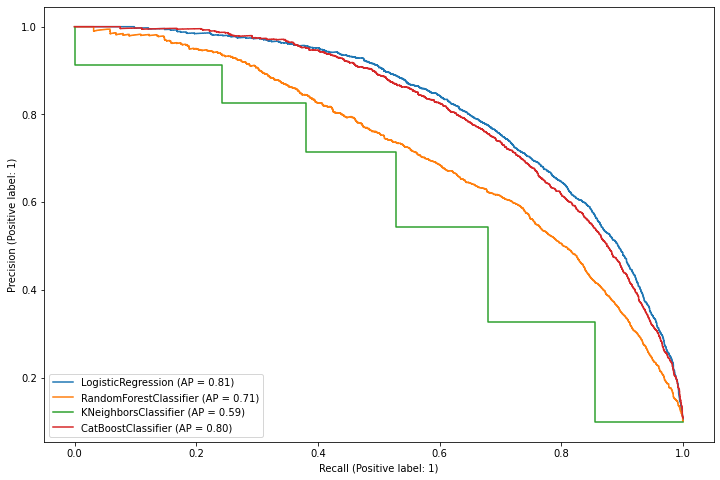

In [83]:
plt.figure(figsize =(12,8))
roc_disp = plot_precision_recall_curve(logit_searcher_bert, corpus_test_bert, target_test_bert, ax=plt.axes(), name='LogisticRegression')
plot_precision_recall_curve(forest_model_bert, corpus_test_bert, target_test_bert, ax=roc_disp.ax_, name='RandomForestClassifier')
plot_precision_recall_curve(knn_model_bert, corpus_test_bert, target_test_bert, ax=roc_disp.ax_, name='KNeighborsClassifier')
plot_precision_recall_curve(cat_model_bert, corpus_test_bert, target_test_bert, ax=roc_disp.ax_, name='CatBoostClassifier')

### Сравнение результатов моделей обученных на корпусах TF-IDF и Bert

Сравним лучшие рмодели полученные при помощи TF-IDF и предообученного Bert. Для начала построим график precision-recall с лучшими моделями.

C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ярослав\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve 

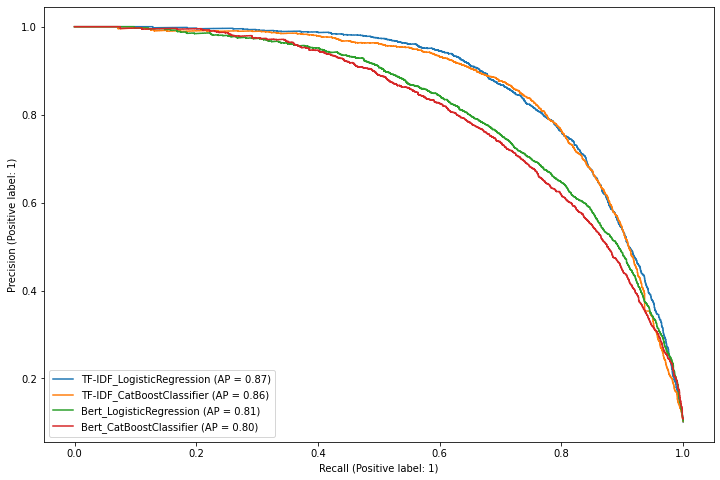

In [84]:
plt.figure(figsize =(12,8))

roc_disp = plot_precision_recall_curve(logit_searcher, corpus_test, target_test, ax=plt.axes(), name='TF-IDF_LogisticRegression')
plot_precision_recall_curve(cat_model, corpus_test, target_test, ax=roc_disp.ax_, name='TF-IDF_CatBoostClassifier')
plot_precision_recall_curve(logit_searcher_bert, corpus_test_bert, target_test_bert, ax=roc_disp.ax_, name='Bert_LogisticRegression')
plot_precision_recall_curve(cat_model_bert, corpus_test_bert, target_test_bert, ax=roc_disp.ax_, name='Bert_CatBoostClassifier')

Из графика видно, что модели обученные на корпусах, полученных при помощи TF-IDF превосходят модели обученные на предобученном Bert.

Определим время необходимое каждой модели для предсказания на тестовом корпусе.

In [91]:
%%time
predictions = logit_searcher.predict(corpus_test)
print('Результат f1 для линейной модели после подбора uиперпараметра C равен', f1_score(target_test, predictions))

Результат f1 для линейной модели после подбора uиперпараметра C равен 0.7711413364872857
CPU times: total: 15.6 ms
Wall time: 14 ms


In [100]:
%%time
predictions = cat_model.predict(corpus_test)
print('Результат f1 для модели CatBoost после подбора гиперпараметров',f1_score(target_test, predictions))

Результат f1 для модели CatBoost после подбора гиперпараметров 0.7868469370722752
CPU times: total: 1.52 s
Wall time: 349 ms


In [95]:
%%time
predictions = logit_searcher_bert.predict(corpus_test_bert)
print('Результат f1 для тестовой выборки для логистической регресии после кроссвалидации на корпусе Bert равен', f1_score(target_test_bert, predictions))

Результат f1 для тестовой выборки для логистической регресии после кроссвалидации на корпусе Bert равен 0.6457254631227707
CPU times: total: 78.1 ms
Wall time: 77 ms


In [98]:
%%time
predictions = cat_model_bert.predict(corpus_test_bert)
print('Результат f1 для модели CatBoost после подбора гиперпараметров, на корпусе Bert равен',f1_score(target_test_bert, predictions))

Результат f1 для модели CatBoost после подбора гиперпараметров, на корпусе Bert равен 0.7169515446134548
CPU times: total: 859 ms
Wall time: 470 ms


In [103]:
data_comparison = pd.DataFrame({
    'Модель': ['TF-IDF_LogisticRegression', 'TF-IDF_CatBoostClassifier', 'Bert_LogisticRegression', 'Bert_CatBoostClassifier'],
    'precision-recall-AUC':[0.87, 0.86, 0.81, 0.8],
    'CPU times: total [ms]': [15.6, 1520, 78.1, 859],
    'F1': [0.7778, 0.7895, 0.6457, 0.7170]
    
})

display(data_comparison.style.background_gradient(cmap='Blues'))

,Модель,precision-recall-AUC,CPU times: total [ms],F1
0,TF-IDF_LogisticRegression,0.870000,15.600000,0.777800
1,TF-IDF_CatBoostClassifier,0.860000,1520.000000,0.789500
2,Bert_LogisticRegression,0.810000,78.100000,0.645700
3,Bert_CatBoostClassifier,0.800000,859.000000,0.717000


Исходя из полученных данных, можно сделать вывод, что модели на корпусах полученных при помощи TF-IDF показывают лучшее качество, чем корпуса, полученные на предообученном Bertе. Также стоит отметить, что на тесте лучшую метрику показала модель catBoost. Однако, модель логистической регрессии не сильно ей уступила в качестве и также превзошла требуемый порог в 0,75, при этом она имеет лучший показатель precision-recall-AUC и выполняется значительно быстрее, поэтому для решения данной задаче рекомендуется использовать именно данную модель.

### Выводы

В данном разделе были рассмотрены и проанализированы модели: линейная, случайного леса, k ближайших соседей и CatBoost. Данные модели были построенны как на корпусах TF-IDF так и на корпусах Berta. Исходя из полученных результатов можно сделать вывод, что по совокупности характеристик для данной задачи лучше вссего подходит модель логистической регрессии, которая позволила получить метрику f1=0.7778 обученная на корпусах TF-IDF.

## Общие выводы

В ходе данной работы был импортирован и подготовлен датасет. Был проведён анализ, входе которого установлено, что в данных имеется сильный дисбаланс по целевому признаку. Далее была проведена лемматизация, текст был очищен от стоп слов и сформированы корпуса для обучения и для тестирования модели (корпуса были сформированы при помощи TF-IDF и предообученной нейросети Bert).  
На следующем этапе были обучены следующие модели: логистическая регрессия, случайный лес, knn, CatBoost (отдельно для корпусов TF-IDF, отдельно для Berta). После этого был проведён анализ моделей и из всех моделей, по совокупности характеристик, наиболе подходящей оказалась линейная модель обученная на корпусах TF-IDF с метрикой f1=0.7778, что соответствует требованиям задачи. Также для данной задачи можно рекомендовать модель CatBoost, она имеет немного лучшую метрику качества(0.7895), но выполняется значительно медленней линейной модели.